Shape of observations: (4000, 100, 37)
Number of runs: 100
Number of dones: 3
Number of runs with dones: 4000
[ 104  476 2047   15  187  144 2047   97  655   88  169  399   42   63
 2047   70 2047  383 2047  307 2047 2047 2047   67  188  188   91   62
    0  515  261  442  407  568 2047 2047 2047   46 2047 2047  130   79
    0 2047   71 2047 2047  269 2047  294   26  424    0 2047 2047  276
  457 2047 2018  275  227  199  401  312 2047 2047 2047 2047   49  181
  627   31 2047 2047   78   62   56  216  106  396 2047   61  569 2047
  107  129  375  213  396  191  400 2047  173 2047   78 2047  246   22
 2047  103]
linvel: [[-1.8252464e-04  6.7395560e-04  3.7604234e-05]
 [ 7.0539711e-04 -1.9519500e-04  1.3459053e-04]
 [-5.4238125e-04 -6.5115269e-04 -4.0902738e-05]
 [-4.7618395e-04 -6.6733052e-04  2.9058798e-04]]
angvel: [[ 0.47857544  0.15093982 -0.382269  ]
 [-0.21203034 -0.17790931  0.85324425]
 [-0.4332122   0.36617076 -0.08475967]
 [-0.57091373  0.25638905 -0.34675807]]
Payload shape (

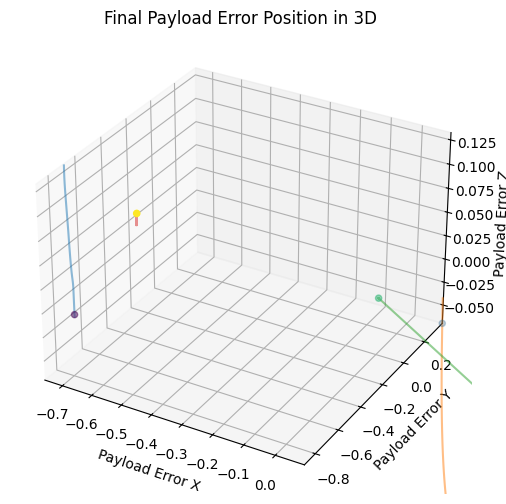

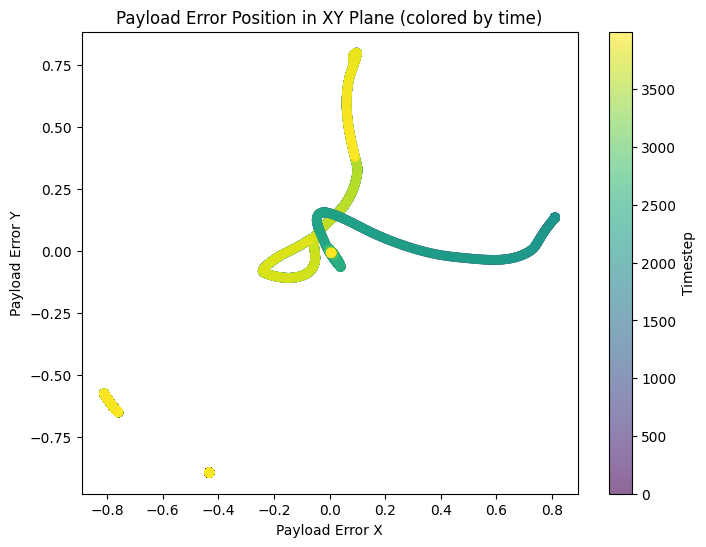

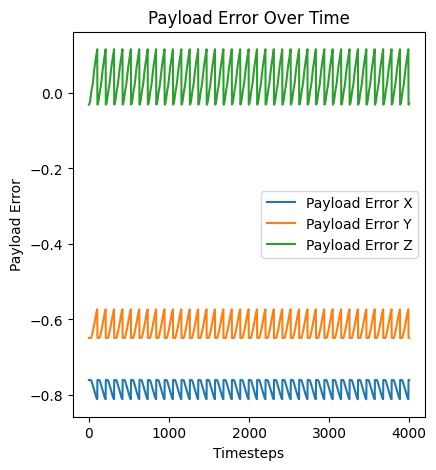

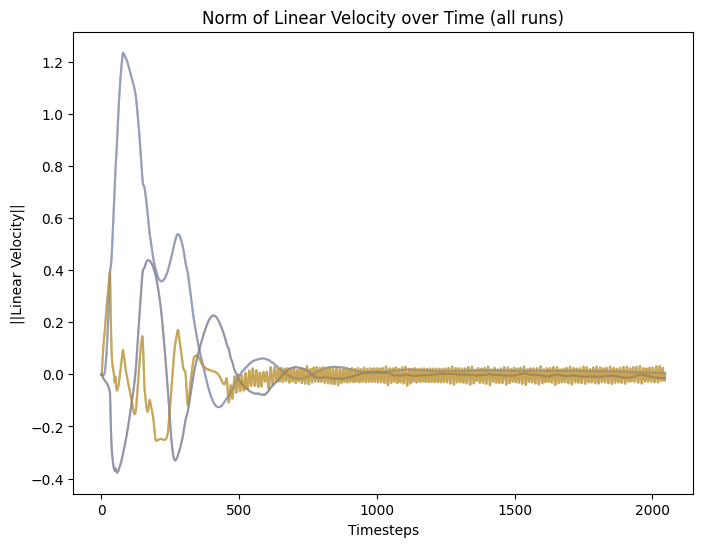

In [8]:
import asdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

# Path to your ASDF file
file_path = 'flights.crazy.asdf'

# Load the ASDF file and read the observations into memory
with asdf.open(file_path) as af:
    obs = np.array(af['flights'][0]['agents']['agent_1']['observations'])
    dones = np.array(af['flights'][0]['global']['dones'])


print("Shape of observations:", obs.shape)



num_runs = 4
#count dones
num_dones = np.sum(dones[0, :])
print(f"Number of runs: {obs.shape[1]}")
print(f"Number of dones: {num_dones}")

# count runs with dones
runs_with_dones = np.sum(np.any(dones, axis=1))
print(f"Number of runs with dones: {runs_with_dones}")

# find index of first done
first_dones = np.argmax(dones,axis=0)
print(first_dones)



#Dynamic ix4 mapping: {'agent_0': [(0, 2), (3, 5), (30, 32), (6, 29), (54, 57)], 'agent_1': [(0, 2), (3, 5), (6, 8), (30, 53), (58, 61)]}
# Extract payload error (X, Y, Z) for the first num_runs environments
timesteps = obs.shape[0]
time = np.arange(timesteps)
payload = obs[:, :num_runs, 0:3]  # shape (timesteps, num_runs, 3)
payload_velocity = obs[:, :num_runs, 3:6]  # shape (timesteps, num_runs, 3)
other_quads = obs[:, :num_runs, 6:9]  # shape (timesteps, num_runs, 3)

#obs_list = [payload_error, payload_linvel, rel, rot, linvel, angvel, linear_acc, angular_acc]
q_pos = obs[:, :num_runs, 9:12]  # shape (timesteps, num_runs, 3)
q_rot_mat = obs[:, :num_runs, 12:21]  # shape (timesteps, num_runs, 9)
q_linvel = obs[:, :num_runs, 21:24]  # shape (timesteps, num_runs, 3)
q_angvel = obs[:, :num_runs, 24:27]  # shape (
q_linacc = obs[:, :num_runs, 27:30]  # shape (timesteps, num_runs, 3)
q_angacc = obs[:, :num_runs, 30:33]  # shape (timesteps, num_runs, 3)
q_last_action = obs[:, :num_runs, 33:36]  # shape (timesteps, num_runs, 3)










print("linvel:", q_linvel[0,:4,:])
print("angvel:", q_angvel[0,:4,:])

# Create 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

print(f"Payload shape (timesteps, runs, dims): {payload.shape}")

# Plot final positions in 3D
final_pos = payload[-1]
xs, ys, zs = final_pos[:, 0], final_pos[:, 1], final_pos[:, 2]
ax.scatter(xs, ys, zs, c=range(num_runs), cmap='viridis', depthshade=True)

# render path
for run in range(num_runs):

    path = payload[2000:2100, run, :]  # Extract the path for each run
    ax.plot(path[:, 0], path[:, 1], path[:, 2], alpha=0.5)  # Plot the path
# Set limits for better visualization
ax.set_xlim([np.min(xs), np.max(xs)])
ax.set_ylim([np.min(ys), np.max(ys)])
ax.set_zlim([np.min(zs), np.max(zs)])

# Labels and title
ax.set_xlabel('Payload Error X')
ax.set_ylabel('Payload Error Y')
ax.set_zlabel('Payload Error Z')
ax.set_title('Final Payload Error Position in 3D')

# plot only in xy plane with color based on time
fig2, ax2 = plt.subplots(figsize=(8, 6))
start, end = 0, 4000
times = np.arange(start, end)
for run in range(num_runs):
    path = payload[start:end, run, :]
    sc = ax2.scatter(path[:, 0], path[:, 1], c=times, cmap='viridis', alpha=0.6)
ax2.set_xlabel('Payload Error X')
ax2.set_ylabel('Payload Error Y')
ax2.set_title('Payload Error Position in XY Plane (colored by time)')
cbar = fig2.colorbar(sc, ax=ax2)
cbar.set_label('Timestep')
# Show the plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(time, payload[:, 0, 0], label='Payload Error X')
plt.plot(time, payload[:, 0, 1], label='Payload Error Y')
plt.plot(time, payload[:, 0, 2], label='Payload Error Z')
plt.xlabel('Timesteps')
plt.ylabel('Payload Error')
plt.title('Payload Error Over Time')
plt.legend()

# Compute the norm of linear velocity at each timestep for each run
linvel_norm = np.linalg.norm(q_linvel, axis=2)  # shape (timesteps, num_runs)

# Plot all runs
fig3, ax3 = plt.subplots(figsize=(8, 6))
for r in range(num_runs):
    end = first_dones[2]
    linvel_norm = np.linalg.norm(q_linvel[:end,2,:], axis=1)
    ax3.plot(time[:end], q_linvel[:end,2,:], alpha=0.3)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('||Linear Velocity||')
ax3.set_title('Norm of Linear Velocity over Time (all runs)')
plt.show()

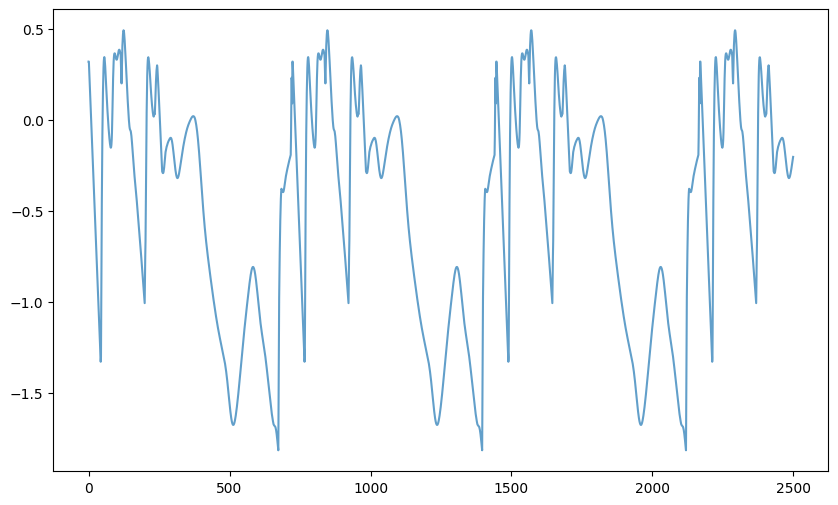

NameError: name 'abs_quad_pos' is not defined

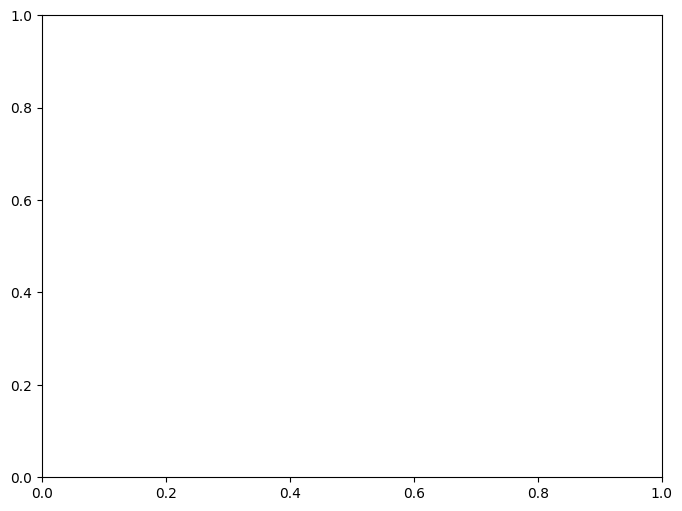